In [1]:
from sympy import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Enable the mathjax printer
init_printing(use_latex='mathjax')

## --> Classe Robot

In [2]:
class Robot:
    def __init__(self, configuration:str, dh_table:Matrix, name:str='Cocoabot', **matrices):
        """
        Initializa o robô com a configuração, tabela DH e matrizes necessárias.   
        """
        self.name = name
        self.joint_types = list(configuration)
        self.dof = len(self.joint_types)

        self.joints = pd.DataFrame(columns=['type', 'theta', 'd', 'a', 'alpha'])
        self.t = symbols('t')
        self.q = [Function(f'q{i+1}')(self.t) for i in range(self.dof)]
        self.dq = [qi.diff(self.t) for qi in self.q]
        self.ddq = [dqi.diff(self.t) for dqi in self.dq]
        self.set_matrices(**matrices)
        self.set_dh_params(dh_table)
        self.get_joints()
        self.compute()

    def set_matrices(self, **matrices):
        """
        Estabelece as matrizes necessárias para a dinâmica do robô.
        Se não forem fornecidas, usa símbolos simbólicos para as matrizes.
        Matrizes:
        - masses:     Matriz com as massas dos links: [m1, m2, m3].T (nx1)
        - r_cis:      Matriz com o centro de massa de cada link (local): [ci1, ci2, ci3].T (nx1)
        - inertias:   Matriz com a inércia de cada link: [[I11:4], [I21:4], [I31:4]] n*(3x3)
        - g_vec:      Matriz com o vetor de gravidade: [0 0 -g].T (3x1)
        """
        self.masses_symbols = Matrix(symbols(f'm1:{self.dof+1}'))
        self.masses = matrices.get('masses', self.masses_symbols)
        self.r_cis_local = matrices.get('r_cis', [Matrix(symbols(f'r_{i+1}x:z')) for i in range(self.dof)])
        self.inertias_symbols = [symbols(f'I{i+1}_1:4_1:4') for i in range(3)]
        self.inertias = matrices.get('inertias', [Matrix(3,3,self.inertias_symbols[i]) for i in range(self.dof)])
        self.g_symbol = symbols('g')
        self.g_vec = matrices.get('g_vec', Matrix([0, 0, -self.g_symbol]))
    
    def set_dh_params(self, dh_table):
        """
        Estabelece os parâmetros DH do robô.
        """
        self.thetas = dh_table[:,0]
        self.ds = dh_table[:,1]
        self._as_ = dh_table[:,2]
        self.alphas = dh_table[:,3]
    
    def get_joints(self):
        """
        Converte os parâmetros DH em um DataFrame com as informações das juntas.
        Transforma os parâmetros simbólicos q em funções de tempo q(t).
        """
        q = symbols(f'q_1:{self.dof+1}')
        for tp in self.joint_types:
            if tp == 'R': self.thetas = self.thetas.subs(zip(q,self.q))
            if tp == 'P': self.ds = self.ds.subs(zip(q,self.q))
        self.joints = pd.DataFrame(list(zip(self.joint_types, Matrix(self.thetas), self.ds, self._as_, self.alphas)), 
                                   columns=['type', 'theta', 'd', 'a', 'alpha'], 
                                   index=np.arange(self.dof)+1)
    
    def compute(self):
        """
        Calcula todas as matrizes necessárias para a dinâmica do robô.
        """
        # Kynematics
        self.dh_matrices = [self.compute_dh_matrix(joint_index=i+1) for i in range(self.dof)]
        self.base_to_joint = [self.calculate_base_to_joint(joint_end=i+1) for i in range(self.dof)]
        self.base_to_end_effector = self.base_to_joint[-1]
        self.jacobian = self.calculate_jacobian()
        # Center of Mass
        self.r_cis_global = [self.calculate_r_i_ci(joint_index=i+1) for i in range(self.dof)]
        self.jacobian_ci = self.calculate_jacobian(com=True)
        # Dynamics
        self.inertia_matrix = self.calculate_inertia_matrix()
        self.coriolis_matrix = self.calculate_coriolis_matrix()
        self.gravity_vector = self.calculate_gravity_vector()
        self.tau = self.compute_inverse_dynamics()

    def compute_dh_matrix(self, joint_index:int):
        """
        Calcula a matriz de transformação DH para a junta especificada.
        """
        assert joint_index > 0, "Must be positive."
        i = joint_index - 1
        theta, d, a, alpha = self.thetas[i], self.ds[i], self._as_[i], self.alphas[i]
        T = Matrix([[cos(theta), -sin(theta)*cos(alpha), sin(theta)*sin(alpha), a*cos(theta)],
                     [sin(theta), cos(theta)*cos(alpha), -cos(theta)*sin(alpha), a*sin(theta)],
                     [0, sin(alpha), cos(alpha), d],
                     [0, 0, 0, 1]])
        return T
    
    def calculate_joint_to_joint(self, joint_start:int, joint_end:int):
        """
        Calcula a matriz de transformação de uma junta para outra.
        """
        assert joint_start > 0, "Must be positive."
        assert joint_end >= joint_start, "End must be greater than start."
        result = eye(self.dof + 1)
        for i in range(joint_start, joint_end+1):
            result = result @ self.dh_matrices[i-1]
        return simplify(result)
    
    def calculate_base_to_joint(self, joint_end):
        """
        Calcula a matriz de transformação da base para a junta especificada.
        """
        return self.calculate_joint_to_joint(joint_start=1, joint_end=joint_end)
    
    def calculate_base_to_end_effector(self):
        """
        Calcula a matriz de transformação da base para o end-effector.
        """
        return self.calculate_base_to_joint(joint_end=self.dof)
    
    def get_rotation(self, matrix):
        """
        Separa a matriz de rotação do restante da matriz de transformação.
        """
        return matrix[:self.dof,:self.dof]
    
    def get_translation(self, matrix):
        """
        Separa o vetor de translação do restante da matriz de transformação.
        """
        return matrix[:self.dof,-1:]

    def z_i_minus_one(self, joint_index):
        """
        Calcula o vetor z_i-1, que é o eixo de rotação da junta i-1, usado para calcular o Jacobiano.
        """
        result = eye(self.dof)
        for i in range(1, joint_index):
            result = result @ self.get_rotation(self.dh_matrices[i-1])
        # result = self.get_rotation(self.base_to_joint[joint_index-1])
        result = result @ Matrix([0, 0, 1])
        return simplify(result)
    
    def r_i_minus_one_to_n(self, joint_index, joint_ci=None):
        """
        Calcula a posição do link relativo ao end-effector.
        """
        # com = joint_ci is not None
        if not joint_ci:
            return self.get_translation(self.base_to_end_effector - self.base_to_joint[joint_index-1]) \
                    if joint_index > 1 else self.get_translation(self.base_to_end_effector)
        else:
            return self.r_cis_global[joint_ci-1] - self.get_translation(self.base_to_joint[joint_index - 1])

    def calculate_r_i_ci(self, joint_index):
        """
        Calcula a posição do centro de massa do link relativo ao end-effector.
        """
        r_local = Matrix.vstack(self.r_cis_local[joint_index-1], Matrix([1]))
        r_ci_global = self.base_to_joint[joint_index-1] @ r_local
        return simplify(r_ci_global[:-1,:])

    def calculate_jacobian_col_i(self, joint_index:int, joint_ci=None):
        """
        Calcula a coluna i da matriz jacobiana J(q) para o joint_index.
        """
        # com = joint_ci is not None
        if joint_ci:
            if joint_ci < joint_index:
                return Matrix(6*[0])
        joint_type = self.joint_types[joint_index-1]
        if joint_type == 'R':
            J_vi = Matrix(np.cross(self.z_i_minus_one(joint_index).T, self.r_i_minus_one_to_n(joint_index, joint_ci).T)).T
            J_wi = self.z_i_minus_one(joint_index)
        elif joint_type == 'P':
            J_vi = self.z_i_minus_one(joint_index)
            J_wi = Matrix([0, 0, 0])
        J_i = Matrix(np.vstack((J_vi, J_wi)))
        return simplify(J_i)

    def calculate_jacobian(self, com=False):
        """
        Calcula a matriz jacobiana J(q). [6 x n]
        - Se com=True, calcula a jacobiana considerando o centro de massa de cada link.
        """
        if not com:
            return Matrix(np.hstack(tuple((self.calculate_jacobian_col_i(i+1) for i in range(self.dof)))))
        else:
            return [Matrix(np.hstack(tuple((self.calculate_jacobian_col_i(j+1, i+1) 
                    for j in range(self.dof)))))
                    for i in range(self.dof)]

    def calculate_inertia_matrix(self):
        """
        Calcula a matriz de inércia M(q). [n x n]
        """
        inertia_matrix = zeros(self.dof, self.dof)

        for i in range(self.dof):
            jv = self.jacobian_ci[i][:3, :]
            jw = self.jacobian_ci[i][3:, :]
            inertia_matrix += self.masses[i] * (jv.T @ jv) + (jw.T @ self.inertias[i] @ jw)

        return simplify(inertia_matrix)

    def calculate_coriolis_matrix(self):
        """
        Calcula a matriz de Coriolis C(q, dq). [n x n]
        """
        n = self.dof
        M = self.inertia_matrix
        C = zeros(n, n)
        for i in range(n):
            for j in range(n):
                for k in range(n):
                    c_ijk = 0.5 * (diff(M[i, k], self.q[j]) + diff(M[i, j], self.q[k]) - diff(M[j, k], self.q[i]))
                    C[i, j] += c_ijk * self.dq[k]

        return simplify(C)

    def calculate_gravity_vector(self):
        """
        Calcula o vetor de gravidade G(q). [n x 1]
        """
        U = 0
        for i, com in enumerate(self.r_cis_global):
            U += self.masses[i] * self.g_vec.dot(com)
        # Differentiating the total potential energy
        G = Matrix([diff(U, q_i) for q_i in self.q])
        return G
    
    def compute_inverse_dynamics(self):
        """
        Cálculo dos tau necessários para a dinâmica inversa do robô. [n x 1]
        """
        self.q_d = [Function(f'q_{i+1}d')(self.t) for i in range(self.dof)]
        self.dq_d = [qi.diff(self.t) for qi in self.q_d]
        self.ddq_d = [dqi.diff(self.t) for dqi in self.dq_d]

        M = self.inertia_matrix
        C = self.coriolis_matrix
        G = self.gravity_vector
        tau = M.subs(zip(self.q,self.q_d)) @ Matrix(self.ddq_d) + \
              C.subs(zip(self.dq, self.dq_d)).subs(zip(self.q,self.q_d)) @ Matrix(self.dq_d) + \
              G.subs(zip(self.q,self.q_d))
        return simplify(tau)

    def eval_dinamics(self, tau, q_d=None, dq_d=None, ddq_d=None):
        """
        Substituição dos valores das variáveis q, dq e ddq na equação de tau simbólica.
        """
        # Importante manter esta ordem!
        if ddq_d: tau = tau.subs(zip(self.ddq_d, ddq_d))
        if dq_d: tau = tau.subs(zip(self.dq_d, dq_d))
        if q_d: tau = tau.subs(zip(self.q_d, q_d))
        return tau.simplify()
    
    def eval_matrix(self, matrix, q=None, dq=None, ddq=None):
        """
        Substituição dos valores das variáveis q, dq e ddq em matrizes simbólicas.
        """
        # Importante manter esta ordem!
        if ddq: matrix = matrix.subs(zip(self.ddq, ddq))
        if dq: matrix = matrix.subs(zip(self.dq, dq))
        if q: matrix = matrix.subs(zip(self.q, q))
        return matrix.simplify()

## --> Definição do robô

In [3]:
# == Definir a Configuração == #
configuration = 'RRP'


# == Definir as Massas == #
m1, m2, m3 = Matrix(symbols(f'm_1:4'))
masses = Matrix([m1, 0, m3])            # massas: [m1, 0, m3] (m2 = 0)
L1, L2 = symbols('L_1 L_2')             # Comprimentos: L1 e L2


# == Definir as Inércias == #
# Inércias: [I1x, I1y, I1z],  I2 = 0, I3 = [I3x, I3y, I3z]
inertias = [diag(*symbols('I_1x:z')), diag(0,0,0), diag(*symbols('I_3x:z'))]


# == Definir os Centros de Massa (local) == #
# Centros de massa: [cm1, 0, cm3] (cm2 = 0)
cm1, cm2, cm3 = symbols(f'r_1:4')
r_cis = [Matrix([0, 0, cm]) for cm in [cm1, cm2, cm3]]


# == Definir o Vetor Gravidade (base) == #
g_vec = Matrix([0, 0, -symbols('g')])


# == Definir os parâmetros DH == #
q1, q2, q3 = symbols('q_1:4')
# Versão alternativa (desnecessária, pois já é feito na classe Robot)
# q1, q2, q3 = [Function(f'q{i+1}')(symbols('t')) for i in range(3)]

# == Tabela DH == #
dh_table = Matrix(
    [[q1, L1, 0, pi/2],
    [q2, 0, 0, pi/2],
    [pi/2, q3+L2, 0, 0]]
)

# == Criando o Robô Cocoabot == #
r = Robot(configuration='RRP', dh_table=dh_table, masses=masses, r_cis=r_cis, inertias=inertias)
r.joints

,type,theta,d,a,alpha
1,R,q1(t),L_1,0,pi/2
2,R,q2(t),0,0,pi/2
3,P,pi/2,L_2 + q3(t),0,0


- Testes para adotar na interface

In [4]:
def substitute(data, subs_dict):
    return simplify(data.subs(subs_dict))

# Definição do que vamos substituir
substitution_dict = {
    'm_1':0.9112, 'm_3':1.3446,
    'I_1x':1.6209e-5, 'I_1y':1.5989e-5, 'I_1z':9.6796e-7,
    'I_3x':1.2403e-4, 'I_3y':2.4632e-4, 'I_3z':1.2389e-4,
    'r_1':0.080, "r_2":0, 'r_3':0.233,      # r_2 = 0
    'L_1':0.3, 'L_2':0.5870,                # L_1 = 0.3
    'g':9.81
}

In [5]:
r = Robot(configuration='RRP', 
          dh_table=substitute(dh_table, substitution_dict), 
          masses=substitute(masses, substitution_dict), 
          r_cis=[substitute(r_ci, substitution_dict) for r_ci in r_cis], 
          inertias=[substitute(inertia, substitution_dict) for inertia in inertias],
          g_vec=substitute(g_vec, substitution_dict)
)

r.joints

,type,theta,d,a,alpha
1,R,q1(t),0.300000000000000,0,pi/2
2,R,q2(t),0,0,pi/2
3,P,pi/2,q3(t) + 0.587,0,0


In [6]:
r.base_to_end_effector[:3,3]

⎡(q₃(t) + 0.587)⋅sin(q₂(t))⋅cos(q₁(t))⎤
⎢                                     ⎥
⎢(q₃(t) + 0.587)⋅sin(q₁(t))⋅sin(q₂(t))⎥
⎢                                     ⎥
⎣  -(q₃(t) + 0.587)⋅cos(q₂(t)) + 0.3  ⎦

In [7]:
r.base_to_joint

⎡⎡cos(q₁(t))  0  sin(q₁(t))    0 ⎤  ⎡cos(q₁(t))⋅cos(q₂(t))  sin(q₁(t))   sin(q ↪
⎢⎢                               ⎥  ⎢                                          ↪
⎢⎢sin(q₁(t))  0  -cos(q₁(t))   0 ⎥  ⎢sin(q₁(t))⋅cos(q₂(t))  -cos(q₁(t))  sin(q ↪
⎢⎢                               ⎥, ⎢                                          ↪
⎢⎢    0       1       0       0.3⎥  ⎢     sin(q₂(t))             0             ↪
⎢⎢                               ⎥  ⎢                                          ↪
⎣⎣    0       0       0        1 ⎦  ⎣          0                 0             ↪

↪ ₂(t))⋅cos(q₁(t))   0 ⎤  ⎡sin(q₁(t))   -cos(q₁(t))⋅cos(q₂(t))  sin(q₂(t))⋅cos ↪
↪                      ⎥  ⎢                                                    ↪
↪ ₁(t))⋅sin(q₂(t))   0 ⎥  ⎢-cos(q₁(t))  -sin(q₁(t))⋅cos(q₂(t))  sin(q₁(t))⋅sin ↪
↪                      ⎥, ⎢                                                    ↪
↪ -cos(q₂(t))       0.3⎥  ⎢     0            -sin(q₂(t))             -cos(q₂(t ↪
↪                      ⎥  ⎢

In [8]:
[r.eval_matrix(matrix=base_to_joint_i[:3,3], q=[0.2,.5,.8]) for base_to_joint_i in r.base_to_joint]

⎡⎡ 0 ⎤  ⎡ 0 ⎤  ⎡0.651708229418978 ⎤⎤
⎢⎢   ⎥  ⎢   ⎥  ⎢                  ⎥⎥
⎢⎢ 0 ⎥, ⎢ 0 ⎥, ⎢0.132107798326815 ⎥⎥
⎢⎢   ⎥  ⎢   ⎥  ⎢                  ⎥⎥
⎣⎣0.3⎦  ⎣0.3⎦  ⎣-0.917207013341947⎦⎦

In [9]:
a = r.eval_matrix(matrix=r.base_to_end_effector[:3,3], q=[0,.5,.8])

In [10]:
a, b, c = np.array(a, dtype=float).flatten()

In [11]:
pos = [r.eval_matrix(matrix=b2j[:3,3], q=[0,.5,.8]) for b2j in r.base_to_joint]
[np.array(posi, dtype=float).flatten() for posi in pos]

[array([0. , 0. , 0.3]),
 array([0. , 0. , 0.3]),
 array([ 0.66496322,  0.        , -0.91720701])]

## --> Parâmetros da Classe Robot

In [8]:
# DH Parameters
# r.thetas, r.ds, r._as_, r.alphas

In [9]:
# DOF, q, dq, ddq, 
# r.dof, r.q, r.dq, r.ddq

In [10]:
# Masses, Inertias, gravity vector
# r.masses, r.inertias, r.g_vec

In [17]:
# Position of center of mass (local and global)
# r.r_cis_local, r.r_cis_global

In [18]:
# Transition Matrix: i-1 -> i
# r.dh_matrices

In [19]:
# Transition Matrix: 0 -> i
# r.base_to_joint

In [20]:
# Transition Matrix: 0 -> n (dof) [from base to end effector]
# r.base_to_end_effector

In [21]:
# Jacobian (end effector)
# r.jacobian

In [22]:
# Jacobian for each center of mass
# r.jacobian_ci

### Inercia, Coriolis, gravidade e Torque

- Resultados simbólicos obtidos para Inercia (M), Coriolis (C), gravidade (G) e torque (tau)

In [23]:
# Matriz de Inércia
r.inertia_matrix

⎡         2       2                            2                        2      ↪
⎢1.3446⋅q₃ (t)⋅sin (q₂(t)) + 2.205144⋅q₃(t)⋅sin (q₂(t)) + 0.90410904⋅sin (q₂(t ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                               0                              ↪
⎢                                                                              ↪
⎣                                               0                              ↪

↪                                                                              ↪
↪ )) + 0.00595653796                                        0                  ↪
↪                                                                              ↪
↪                              2                                               ↪
↪                     1.3446⋅q₃ (t) + 2.205144⋅q₃(t) - 0.000122289999999969⋅si ↪
↪                          

In [24]:
# Matriz de Coriolis
r.coriolis_matrix

⎡                                                                              ↪
⎢                                                                              ↪
⎢⎛                                     d           ⎛         2                 ↪
⎢⎜(1.3446⋅q₃(t) + 1.102572)⋅sin(q₂(t))⋅──(q₃(t)) + ⎝1.3446⋅q₃ (t) + 2.205144⋅q ↪
⎢⎝                                     dt                                      ↪
⎢                                                                              ↪
⎢        ⎛         2                                 ⎞              d          ↪
⎢        ⎝1.3446⋅q₃ (t) + 2.205144⋅q₃(t) + 0.90410904⎠⋅sin(2⋅q₂(t))⋅──(q₁(t))  ↪
⎢                                                                   dt         ↪
⎢      - ────────────────────────────────────────────────────────────────────  ↪
⎢                                         2                                    ↪
⎢                                                                              ↪
⎢                           

In [25]:
# Vetor de Gravidade
simplify(r.gravity_vector)

⎡                     0                     ⎤
⎢                                           ⎥
⎢(-13.190526⋅q₃(t) - 10.81623132)⋅sin(q₂(t))⎥
⎢                                           ⎥
⎣           13.190526⋅cos(q₂(t))            ⎦

In [26]:
# tau e Forças (Tau)
r.tau

⎡                                                                              ↪
⎢                                                                              ↪
⎢⎛                                         d             ⎛           2         ↪
⎢⎜(1.3446⋅q_3d(t) + 1.102572)⋅sin(q_2d(t))⋅──(q_3d(t)) + ⎝1.3446⋅q_3d (t) + 2. ↪
⎢⎝                                         dt                                  ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢              ⎛                            d                                  ↪
⎢              ⎜(1.3446⋅q_3d(t) + 1.102572)⋅──(q_3d(t)) - 6.11449999999847e-5⋅ ↪
⎢              ⎝                            dt                                 ↪
⎢                           

## --> Substituição de Parâmetros

- Visualização de quais parâmetros podem ser substituidos.
- Realiza a substituição para as matrizes M, C e G.

In [27]:
# Confere o que da pra substituir (exemplo com variável tau)
print('Da pra substituir essas variaveis:', end=' ')
print(r.tau.free_symbols)
print(f'\nSimbolos:')
r.tau.free_symbols

Da pra substituir essas variaveis: {t}

Simbolos:


{t}

In [28]:
# Definição do que vamos substituir
substitution_dict = {
    'm_1':0.9112, 'm_3':1.3446,
    'I_1x':1.6209e-5, 'I_1y':1.5989e-5, 'I_1z':9.6796e-7,
    'I_3x':1.2403e-4, 'I_3y':2.4632e-4, 'I_3z':1.2389e-4,
    'r_1':0.080, 'r_3':0.233,
    'L_2':0.5870,
    'g':9.81
}

In [29]:
r.eval_matrix(r.inertia_matrix)

⎡         2       2                            2                        2      ↪
⎢1.3446⋅q₃ (t)⋅sin (q₂(t)) + 2.205144⋅q₃(t)⋅sin (q₂(t)) + 0.90410904⋅sin (q₂(t ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                               0                              ↪
⎢                                                                              ↪
⎣                                               0                              ↪

↪                                                                              ↪
↪ )) + 0.00595653796                                        0                  ↪
↪                                                                              ↪
↪                              2                                               ↪
↪                     1.3446⋅q₃ (t) + 2.205144⋅q₃(t) - 0.000122289999999969⋅si ↪
↪                          

In [30]:
# Substituindo os valores
# Matriz de inercia
M = r.inertia_matrix
subs_M = simplify(M.subs(substitution_dict))

# Matriz de Coriolis
C = r.coriolis_matrix
subs_C = simplify(C.subs(substitution_dict))

# Vetor de gravidade
G = r.gravity_vector
subs_G = simplify(G.subs(substitution_dict))

subs_M, subs_C, subs_G

⎛                                                                              ↪
⎜                                                                              ↪
⎜                                                                              ↪
⎜                                                                              ↪
⎜⎡         2       2                            2                        2     ↪
⎜⎢1.3446⋅q₃ (t)⋅sin (q₂(t)) + 2.205144⋅q₃(t)⋅sin (q₂(t)) + 0.90410904⋅sin (q₂( ↪
⎜⎢                                                                             ↪
⎜⎢                                                                             ↪
⎜⎢                                               0                             ↪
⎜⎢                                                                             ↪
⎜⎣                                               0                             ↪
⎜                                                                              ↪
⎜                           

## --> Trajetória desejada

- Feito através de um polinômio quíntuplo

In [31]:
def coeff_traj(q0, qf, tf):
    """
    Calcula os coeficientes do polinômio de quinta ordem para a trajetória entre q0 e qf em tf segundos.
    """
    D = qf - q0
    a0 = q0
    a1 = 0
    a2 = 0
    a3 = 10 * D / tf**3
    a4 = -15 * D / tf**4
    a5 = 6 * D / tf**5
    return a0, a1, a2, a3, a4, a5

def calc_traj(a, t):
    """
    Calcula a trajetória, velocidade e aceleração a partir dos coeficientes do polinômio de quinta ordem.
    """
    q   = a[0] + a[1]*t + a[2]*t**2 + a[3]*t**3 + a[4]*t**4 + a[5]*t**5
    qd  = a[1] + 2*a[2]*t + 3*a[3]*t**2 + 4*a[4]*t**3 + 5*a[5]*t**4
    qdd = 2*a[2] + 6*a[3]*t + 12*a[4]*t**2 + 20*a[5]*t**3
    return q, qd, qdd


# Definindo a trajetória: 
# q0 = posição inicial, qf = posição final, tf = tempo final
q0 = np.array([0, np.pi/2, 0])
qf = np.array([np.pi/2, (3/4)*np.pi, 0.08])
tf = 5.0 

# Calculando os coeficientes do polinômio de quinta ordem para cada junta
coeffs = [coeff_traj(q0[i], qf[i], tf) for i in range(r.dof)]
# Definindo a trajetórias para cada junta como funções
trajs = [lambda t, c=coeff: calc_traj(c, t) for coeff in coeffs]

# Separando as posições, velocidades e acelerações desejadas
q_d=[trajs[i](r.t)[0] for i in range(r.dof)]
dq_d=[trajs[i](r.t)[1] for i in range(r.dof)]
ddq_d=[trajs[i](r.t)[2] for i in range(r.dof)]

# Exemplo: mostrar as posições da trajetória desejadas de cada junta
q_d

⎡                    5                       4                      3          ↪
⎣0.0030159289474462⋅t  - 0.0376991118430775⋅t  + 0.125663706143592⋅t , 0.00150 ↪

↪              5                       4                       3               ↪
↪ 79644737231⋅t  - 0.0188495559215388⋅t  + 0.0628318530717959⋅t  + 1.570796326 ↪

↪                  5            4           3⎤
↪ 7949, 0.0001536⋅t  - 0.00192⋅t  + 0.0064⋅t ⎦

In [32]:
def coeff_traj2(q0, qf, tf):
        """Calcula os coeficientes do polinômio de quinta ordem para a trajetória entre q0 e qf em tf segundos."""
        D = qf - q0
        a0 = q0
        a1 = 0
        a2 = 0
        a3 = 10 * D / tf**3
        a4 = -15 * D / tf**4
        a5 = 6 * D / tf**5
        return [a0, a1, a2, a3, a4, a5]

def calc_traj2(a, t):
    """Calcula a trajetória, velocidade e aceleração a partir dos coeficientes do polinômio de quinta ordem."""
    q = a[0] + a[1]*t + a[2]*t**2 + a[3]*t**3 + a[4]*t**4 + a[5]*t**5
    qd = a[1] + 2*a[2]*t + 3*a[3]*t**2 + 4*a[4]*t**3 + 5*a[5]*t**4
    qdd = 2*a[2] + 6*a[3]*t + 12*a[4]*t**2 + 20*a[5]*t**3
    return q, qd, qdd

def generate_trajectory(q0, qf, tf, dt=0.01):
    """Gerar trajetória completa"""
    t_grid = np.arange(0, tf + dt, dt)
    
    # Calcular coeficientes para cada junta
    coeffs = [coeff_traj2(q0[i], qf[i], tf) for i in range(3)]
    
    # Gerar trajetórias
    trajectory = []
    for t in t_grid:
        q_t = [calc_traj2(coeffs[i], t)[0] for i in range(3)]
        qd_t = [calc_traj2(coeffs[i], t)[1] for i in range(3)]
        qdd_t = [calc_traj2(coeffs[i], t)[2] for i in range(3)]
        trajectory.append((t, q_t, qd_t, qdd_t))
    return trajectory

In [33]:
q0 = np.array([0, np.pi/2, 0])
qf = np.array([np.pi/2, (3/4)*np.pi, 0.08])
tf = 5.0 
dt = 0.01

In [34]:
generate_trajectory(q0, qf, tf)

[(0.0, [0.0, 1.5707963267948966, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]), (0.0 ↪

↪ 1, [1.2528701661805573e-07, 1.5707963894384047, 6.380815360000001e-09], [3.7 ↪

↪ 548466192152584e-05, 1.8774233096076292e-05, 1.9123276800000003e-06], [0.007 ↪

↪ 494643752982761, 0.0037473218764913804, 0.00038169907200000003]), (0.02, [9. ↪

↪ 992874422264734e-07, 1.5707968264386178, 5.0893291520000006e-08], [0.0001495 ↪

↪ 9248853648957, 7.479624426824478e-05, 7.618682880000001e-06], [0.01489917154 ↪

↪ 9015827, 0.007449585774507913, 0.0007588085760000001]), (0.03, [3.3624570723 ↪

↪ 575065e-06, 1.5707980080234327, 1.7124853248e-07], [0.0003352327170208824, 0 ↪

↪ .0001676163585104412, 1.707326208e-05], [0.022213945299572897, 0.01110697264 ↪

↪ 9786448, 0.001131346944]), (0.04, [7.946276297995813e-06, 1.5708002999330455 ↪

↪ , 4.0470052864e-07], [0.0005935734207479398, 0.0002967867103739699, 3.023044 ↪

↪ 6080000002e-05], [0.02943932691612766, 0.01471966345806383, 0.00149933260800 ↪

↪ 00003]), (0.05

In [35]:
t_grid = np.arange(0, tf + dt, dt)
coeffs = [coeff_traj2(q0[i], qf[i], tf) for i in range(3)]
q_t = calc_traj2(coeffs[0], t_grid)[1]


## --> Exemplo de como a matriz vai se transformando

- Legal de ver como as variáveis vão sendo substituidas:
1. Original
2. Parâmetros substituidos: $I, m, cm, ...$
3. Variáveis substituídas: $q_1, q_2, q_3$ conforme a trajetória desejada (ainda em função de $t$)
4. Transforma em função do Python e avalia para um ponto

In [36]:
# 1. Escolha a matriz: r.inertia_matrix, r.coriolis_matrix, r.gravity_vector
matrix = r.coriolis_matrix
matrix

⎡                                                                              ↪
⎢                                                                              ↪
⎢⎛                                     d           ⎛         2                 ↪
⎢⎜(1.3446⋅q₃(t) + 1.102572)⋅sin(q₂(t))⋅──(q₃(t)) + ⎝1.3446⋅q₃ (t) + 2.205144⋅q ↪
⎢⎝                                     dt                                      ↪
⎢                                                                              ↪
⎢        ⎛         2                                 ⎞              d          ↪
⎢        ⎝1.3446⋅q₃ (t) + 2.205144⋅q₃(t) + 0.90410904⎠⋅sin(2⋅q₂(t))⋅──(q₁(t))  ↪
⎢                                                                   dt         ↪
⎢      - ────────────────────────────────────────────────────────────────────  ↪
⎢                                         2                                    ↪
⎢                                                                              ↪
⎢                           

In [37]:
# 2. Com parametros substituidos
subs_matrix = matrix.subs(substitution_dict).simplify()
subs_matrix

⎡                                                                              ↪
⎢                                                                              ↪
⎢⎛                                     d           ⎛         2                 ↪
⎢⎜(1.3446⋅q₃(t) + 1.102572)⋅sin(q₂(t))⋅──(q₃(t)) + ⎝1.3446⋅q₃ (t) + 2.205144⋅q ↪
⎢⎝                                     dt                                      ↪
⎢                                                                              ↪
⎢        ⎛         2                                 ⎞              d          ↪
⎢        ⎝1.3446⋅q₃ (t) + 2.205144⋅q₃(t) + 0.90410904⎠⋅sin(2⋅q₂(t))⋅──(q₁(t))  ↪
⎢                                                                   dt         ↪
⎢      - ────────────────────────────────────────────────────────────────────  ↪
⎢                                         2                                    ↪
⎢                                                                              ↪
⎢                           

In [38]:
# 3. Com variaveis substituidas q(t), dq(t), ddq(t)
t_matrix = r.eval_matrix(matrix=subs_matrix, 
                        q=q_d,
                        dq=dq_d,
                        ddq=ddq_d
                       )
t_matrix

⎡                                                                              ↪
⎢   ⎛                                                                          ↪
⎢ 2 ⎜⎛          2                     ⎞ ⎛               5                4     ↪
⎢t ⋅⎝⎝0.000768⋅t  - 0.00768⋅t + 0.0192⎠⋅⎝0.00020653056⋅t  - 0.002581632⋅t  + 0 ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                                         ⎛    ↪
⎢                                                                       2 ⎜⎛   ↪
⎢                                                                      t ⋅⎝⎝-  ↪
⎢                                                                      ─────── ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                           

In [39]:
# 4. Como funcao: matrix(t)
tgrid = np.linspace(0, tf, 300)
matrix_func = lambdify('t', t_matrix)

# Escolha um ponto pra avaliar
i = 150
print('t (s) = ', tgrid[i])
Matrix(matrix_func(t=tgrid[i]))

t (s) =  2.508361204013378


⎡ -0.0745632196881   -0.208223931712178  0.580365061634746⎤
⎢                                                         ⎥
⎢0.208223931712178   0.0346640070357867  0.340666667991439⎥
⎢                                                         ⎥
⎣-0.580365061634746  -0.340666667991439         0.0       ⎦

In [40]:
# # Outra forma de avaliar a matriz
# ti_matrix = r.eval_matrix(matrix=subs_matrix, 
#                           q=lambdify('t',q)(tgrid[i]),
#                           dq=lambdify('t',dq)(tgrid[i]),
#                           ddq=lambdify('t',ddq)(tgrid[i])
#                        )
# ti_matrix

## --> Cálculo das matrizes de Inercia, Coriolis e Gravidade para a trajetória desejada

In [41]:
subs_M

⎡         2       2                            2                        2      ↪
⎢1.3446⋅q₃ (t)⋅sin (q₂(t)) + 2.205144⋅q₃(t)⋅sin (q₂(t)) + 0.90410904⋅sin (q₂(t ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                               0                              ↪
⎢                                                                              ↪
⎣                                               0                              ↪

↪                                                                              ↪
↪ )) + 0.00595653796                                        0                  ↪
↪                                                                              ↪
↪                              2                                               ↪
↪                     1.3446⋅q₃ (t) + 2.205144⋅q₃(t) - 0.000122289999999969⋅si ↪
↪                          

In [42]:
# Inertia Matrix
M = r.eval_matrix(matrix=subs_M, q=q_d)
M_func = lambdify('t', M)
M = [M_func(t=t) for t in tgrid]

# Coriolis Matrix
C = r.eval_matrix(matrix=subs_C, q=q_d, dq=dq_d)
C_func = lambdify('t', C)
C = [C_func(t=t) for t in tgrid]

# Gravity Vector
G = r.eval_matrix(matrix=subs_G, q=q_d)
G_func = lambdify('t', G)
G = [G_func(t=t) for t in tgrid]

### Cálculo dos valores máximos dentro da trajetória desejada

- Usado no cálculo dos ganhos do controlador PID

In [43]:
# Maximo Inercia
M_max = M[np.argmax([np.linalg.norm(Mi) for Mi in M])]
M_max

array([[0.90798391, 0.        , 0.        ],
       [0.        , 0.9616152 , 0.        ],
       [0.        , 0.        , 1.3446    ]])

In [44]:
# Maximo Coriolis
C_max = C[np.argmax([np.linalg.norm(Ci) for Ci in C])]
C_max

array([[-0.06683354, -0.19380397,  0.59056782],
       [ 0.19380397,  0.03445023,  0.33856492],
       [-0.59056782, -0.33856492,  0.        ]])

## --> Controle PID

- No final tem uma explicação sobre a implementação em versão matemática que fica mais fácil de entender
- Você tem que definir qual *pid* você quer: *'classico'*, *'tc'* (torque calculado) ou *'previo'* (calculados previamentes)

In [45]:
# Especificações do sistema de controle
pid = 'tc'            # PID: 'classico' para PID Clássico, 'tc' para Torque Calculado
ts = 0.3                    # Settling time com 5% tolerância
zeta = 0.59                 # Overshoot de 10%

# Cálculo da frequência natural e alocação de um polo p afastado
wn = 3/(zeta*ts)
p = 5*zeta*wn

zeta, wn, p

(0.59, 16.949152542372882, 50.0)

### Cálculo dos ganhos

In [46]:
# PID Clássico
if pid == 'classico':
    Kp = np.diag(np.diag((wn**2 + 2*zeta*wn*p) * M_max))
    Kd = np.diag(np.diag((2*zeta*wn + p) * M_max - C_max))
    Ki = np.diag(np.diag((wn**2*p) * M_max))

# PID + Torque Calculado
elif pid == 'tc':
    Kp = np.diag(3*[wn**2 + 2*zeta*wn*p])
    Kd = np.diag(3*[2*zeta*wn + p])
    Ki = np.diag(3*[wn**2*p])

Matrix(Kp), Matrix(Kd), Matrix(Ki)

⎛⎡1287.27377190463        0.0               0.0       ⎤  ⎡70.0  0.0   0.0 ⎤  ⎡ ↪
⎜⎢                                                    ⎥  ⎢                ⎥  ⎢ ↪
⎜⎢      0.0         1287.27377190463        0.0       ⎥, ⎢0.0   70.0  0.0 ⎥, ⎢ ↪
⎜⎢                                                    ⎥  ⎢                ⎥  ⎢ ↪
⎝⎣      0.0               0.0         1287.27377190463⎦  ⎣0.0   0.0   70.0⎦  ⎣ ↪

↪ 14363.6885952313        0.0               0.0       ⎤⎞
↪                                                     ⎥⎟
↪       0.0         14363.6885952313        0.0       ⎥⎟
↪                                                     ⎥⎟
↪       0.0               0.0         14363.6885952313⎦⎠

### Implementação do controle e cálculo da trajetória real

In [47]:
# Trajetória desejada
q_ds = np.asarray(lambdify('t',q_d)(tgrid)).T           # Tem que ser (N, 3), por isso .T
dq_ds = np.asarray(lambdify('t',dq_d)(tgrid)).T
ddq_ds = np.asarray(lambdify('t',ddq_d)(tgrid)).T

# Trajetória real
q = np.zeros_like(q_ds)
q[0] = q0
dq = np.zeros_like(dq_ds)
ddq = np.zeros_like(ddq_ds)

# Erros
e = np.zeros_like(q_ds)
tau = np.zeros_like(q_ds)
e_int = np.zeros(3)


N = len(tgrid)
dt = tgrid[1] - tgrid[0]
for k in range(N-1):
    e[k] = q_ds[k] - q[k]
    edot = dq_ds[k] - dq[k]
    e_int += e[k] * dt

    M = np.array(r.eval_matrix(matrix=subs_M, q=list(q[k])), dtype=float)
    C = np.array(r.eval_matrix(matrix=subs_C, q=list(q[k]), dq=list(dq[k])), dtype=float)
    G = np.array(r.eval_matrix(matrix=subs_G, q=list(q[k])), dtype=float).flatten()

    # Cálculo de torque PID
    if pid == 'classico':
        tau[k] = (Kp @ e[k] + Kd @ edot + Ki @ e_int + G)
        ddq[k+1] = np.linalg.solve(M, tau[k] - C @ dq[k] - G)
    elif pid == 'tc':
        tau[k] = M @ (ddq_ds[k] + Kd @ edot + Kp @ e[k] + Ki @ e_int) + C @ dq[k] + G
        ddq[k+1] = np.linalg.solve(M, tau[k] - C @ dq[k] - G)
    
    # Simula próximos valores
    dq[k+1] = dq[k] + ddq[k+1] * dt
    q[k+1] = q[k] + dq[k+1] * dt

## --> Plot dos resultados

- Aqui você tem que escolher qual vc quer visualizar: $q$, $\dot q$, $\ddot q$, $e$, $\tau$
- Escolha também entre visualização única, separada ou individual

### Visualização única

In [48]:
# # Caso quiser converter para graus
# q_deg = np.array([np.rad2deg(q[:,0]), np.rad2deg(q[:,1]), q[:,2]]).T
# q_ds_deg = np.array([np.rad2deg(q_ds[:,0]), np.rad2deg(q_ds[:,1]), q_ds[:,2]]).T

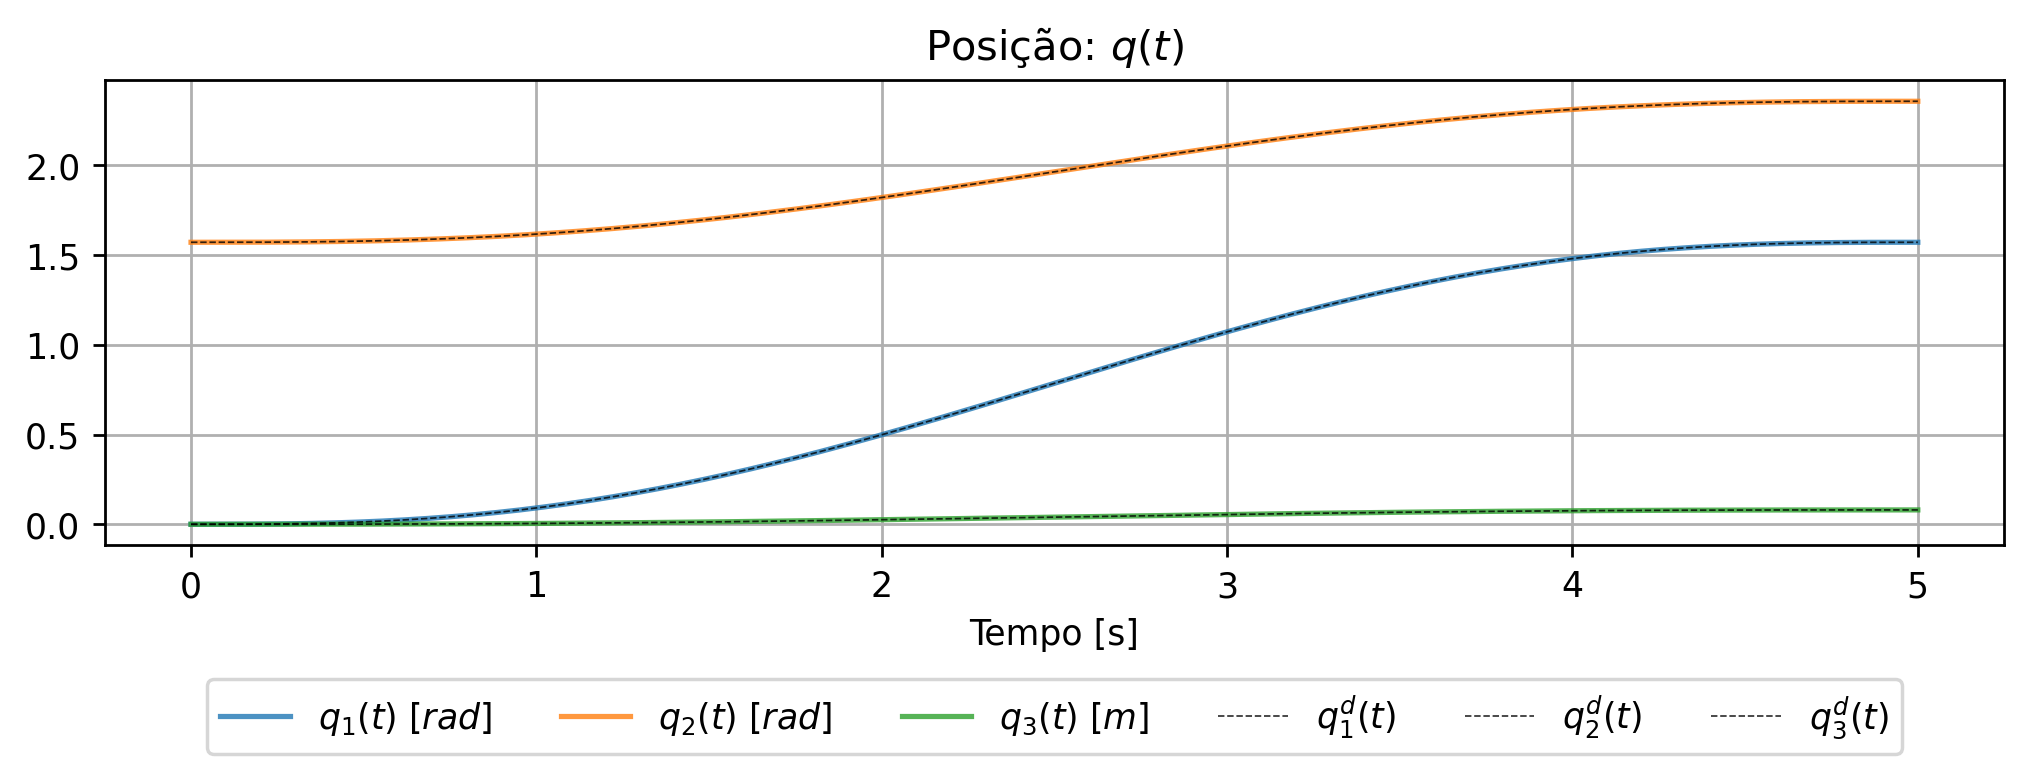

In [50]:
# Plot: Visualização única [todos em 1 gráfico]
plotar = 'q'         # Pode ser 'q', 'dq', 'ddq', 'erro' ou 'tau'

data = {'q': q, 'dq': dq, 'ddq': ddq, 'erro': e, 'tau': tau}
data_d = {'q': q_ds, 'dq': dq_ds, 'ddq': ddq_ds}
title = {'q': 'Posição: $q(t)$', 
         'dq': 'Velocidade: $\\dot q(t)$', 
         'ddq': 'Aceleração: $\\ddot q(t)$', 
         'erro': 'Erro: $e(t) = q_d(t) - q(t)$', 
         'tau': 'Torque|Força: $\\tau(t)$'}
lbl = {'q': [f'$q_{i+1}(t)$' for i in range(r.dof)],
       'dq': [f'$\\dot q_{i+1}(t)$' for i in range(r.dof)],
       'ddq': [f'$\\ddot q_{i+1}(t)$' for i in range(r.dof)],
       'erro': [f'$e_{i+1}(t)$' for i in range(r.dof)],
       'tau': [f'$\\tau_{i+1}(t)$' for i in range(r.dof)]}
lbl_d = {'q': [f'$q_{i+1}^d(t)$' for i in range(r.dof)],
         'dq': [f'$\\dot q_{i+1}^d(t)$' for i in range(r.dof)],
         'ddq': [f'$\\ddot q_{i+1}^d(t)$' for i in range(r.dof)],
         'erro': [f'$e_{i+1}^d(t)$' for i in range(r.dof)],
         'tau': [f'$\\tau_{i+1}^d(t)$' for i in range(r.dof)]}
un = {'q': ['$[rad]$', '$[rad]$', '$[m]$'],
       'dq': ['$[rad/s]$', '$[rad/s]$', '$[m/s]$'],
       'ddq': ['$[rad/s^2]$', '$[rad/s^2]$', '$[m/s^2]$'],
       'erro': ['$[rad]$', '$[rad]$', '$[m]$'],
       'tau': ['$[N.m]$', '$[N.m]$', '$[N]$']}
ylbl = {k: [f'{lbl[k][i]} {un[k][i]}' for i in range(r.dof)] for k in lbl.keys()}


fig, ax = plt.subplots(figsize=(8, 3), dpi=250, layout='constrained')
ax.plot(tgrid, data[plotar], alpha=0.8, label=ylbl[plotar])
if plotar in ['q', 'dq', 'ddq']:
       ax.plot(tgrid, data_d[plotar], linestyle='--', color='k', lw=.5, label=lbl_d[plotar], alpha=.8)
ax.set_title(title[plotar])
ax.set_xlabel('Tempo [s]')
plt.grid()
ax.legend(bbox_to_anchor=(0.5, -0.25), loc='upper center', ncol=(2*r.dof if plotar in ['q', 'dq', 'ddq'] else r.dof))
colors = [ax.lines[i].get_color() for i in range(len(ax.lines))]


### Visualização separada

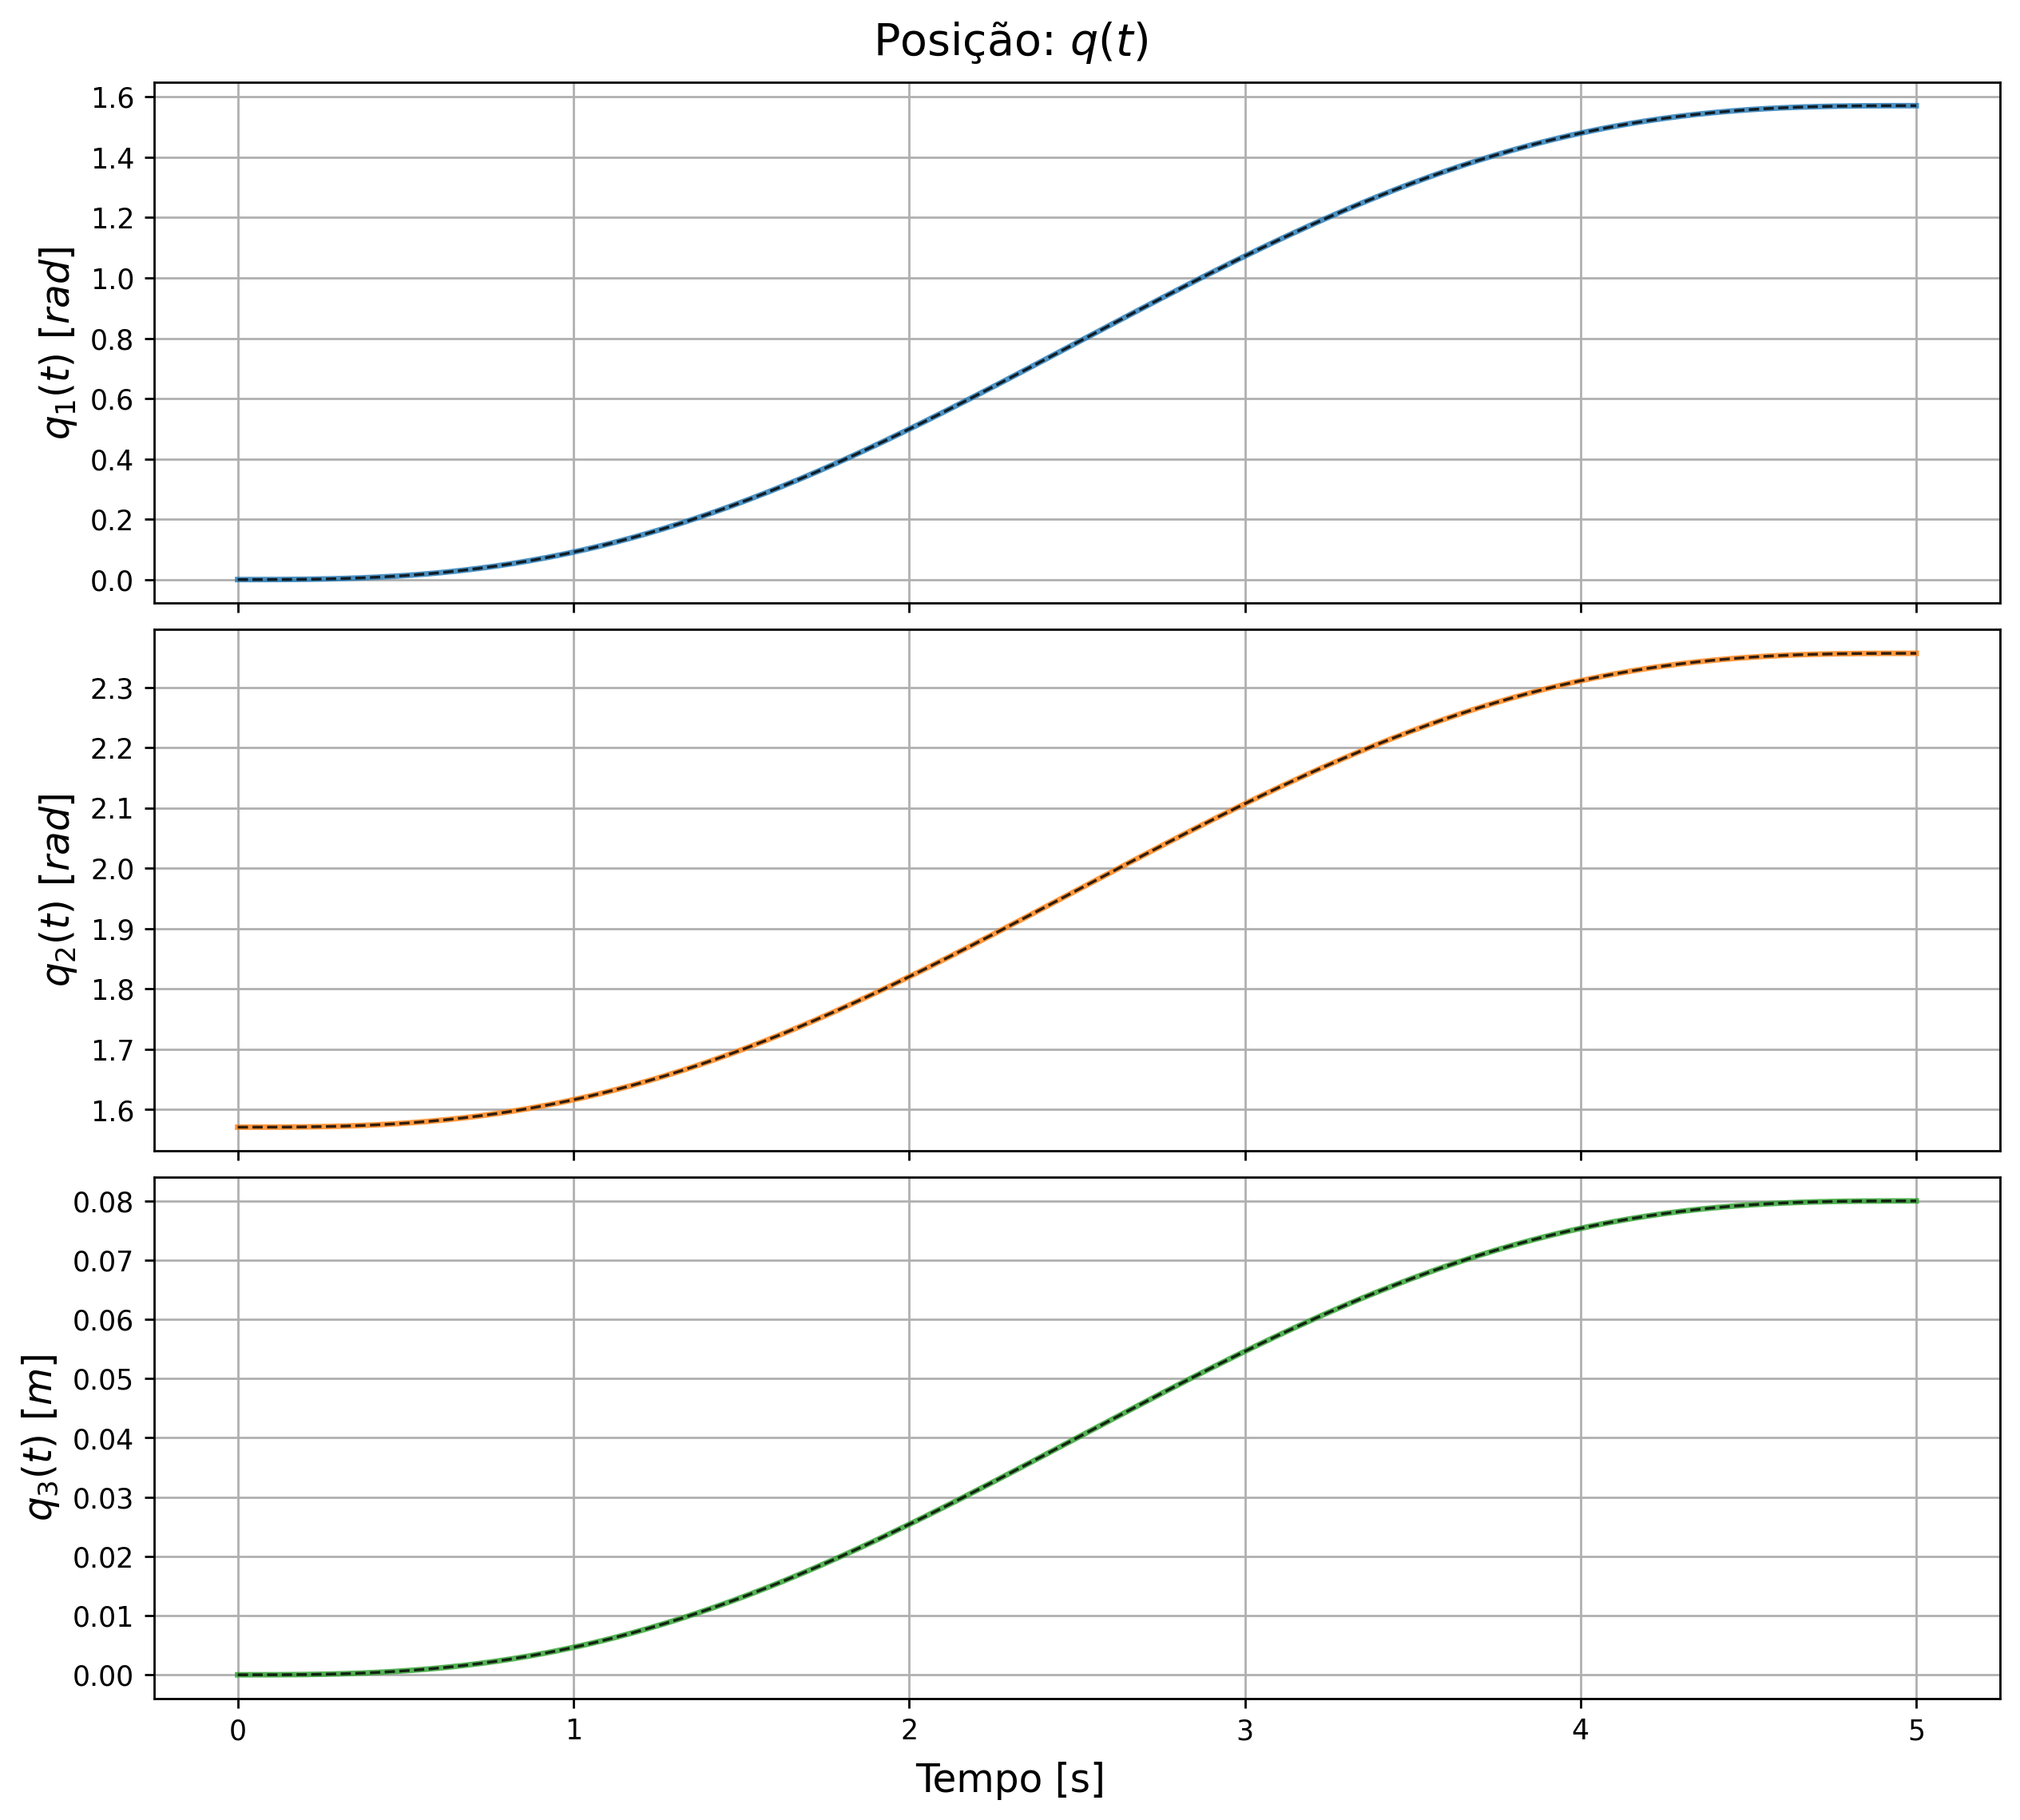

In [49]:
# Plot: Visualização separada [n gráficos]
# plotar = 'dq'         # Pode ser 'q', 'dq', 'ddq', 'erro' ou 'tau'

fig, axs = plt.subplots(3,1, figsize=(10,3*3), layout='constrained', sharex=True, dpi=250)
fig.suptitle(title[plotar], fontsize=16)
fig.supxlabel('Tempo [s]', fontsize=14)
for i, ax in enumerate(axs):
    ax.plot(tgrid, data[plotar].T[i], lw=2, label=lbl[plotar][i], alpha=.8, color=colors[i])
    if plotar in ['q', 'dq', 'ddq']:
       ax.plot(tgrid, data_d[plotar].T[i], linestyle='--', color='k', lw=1, label=lbl_d[plotar][i], alpha=.8)
    ax.set_ylabel(f'{lbl[plotar][i]} {un[plotar][i]}', fontsize=14)
    ax.grid()


### Visualização individual

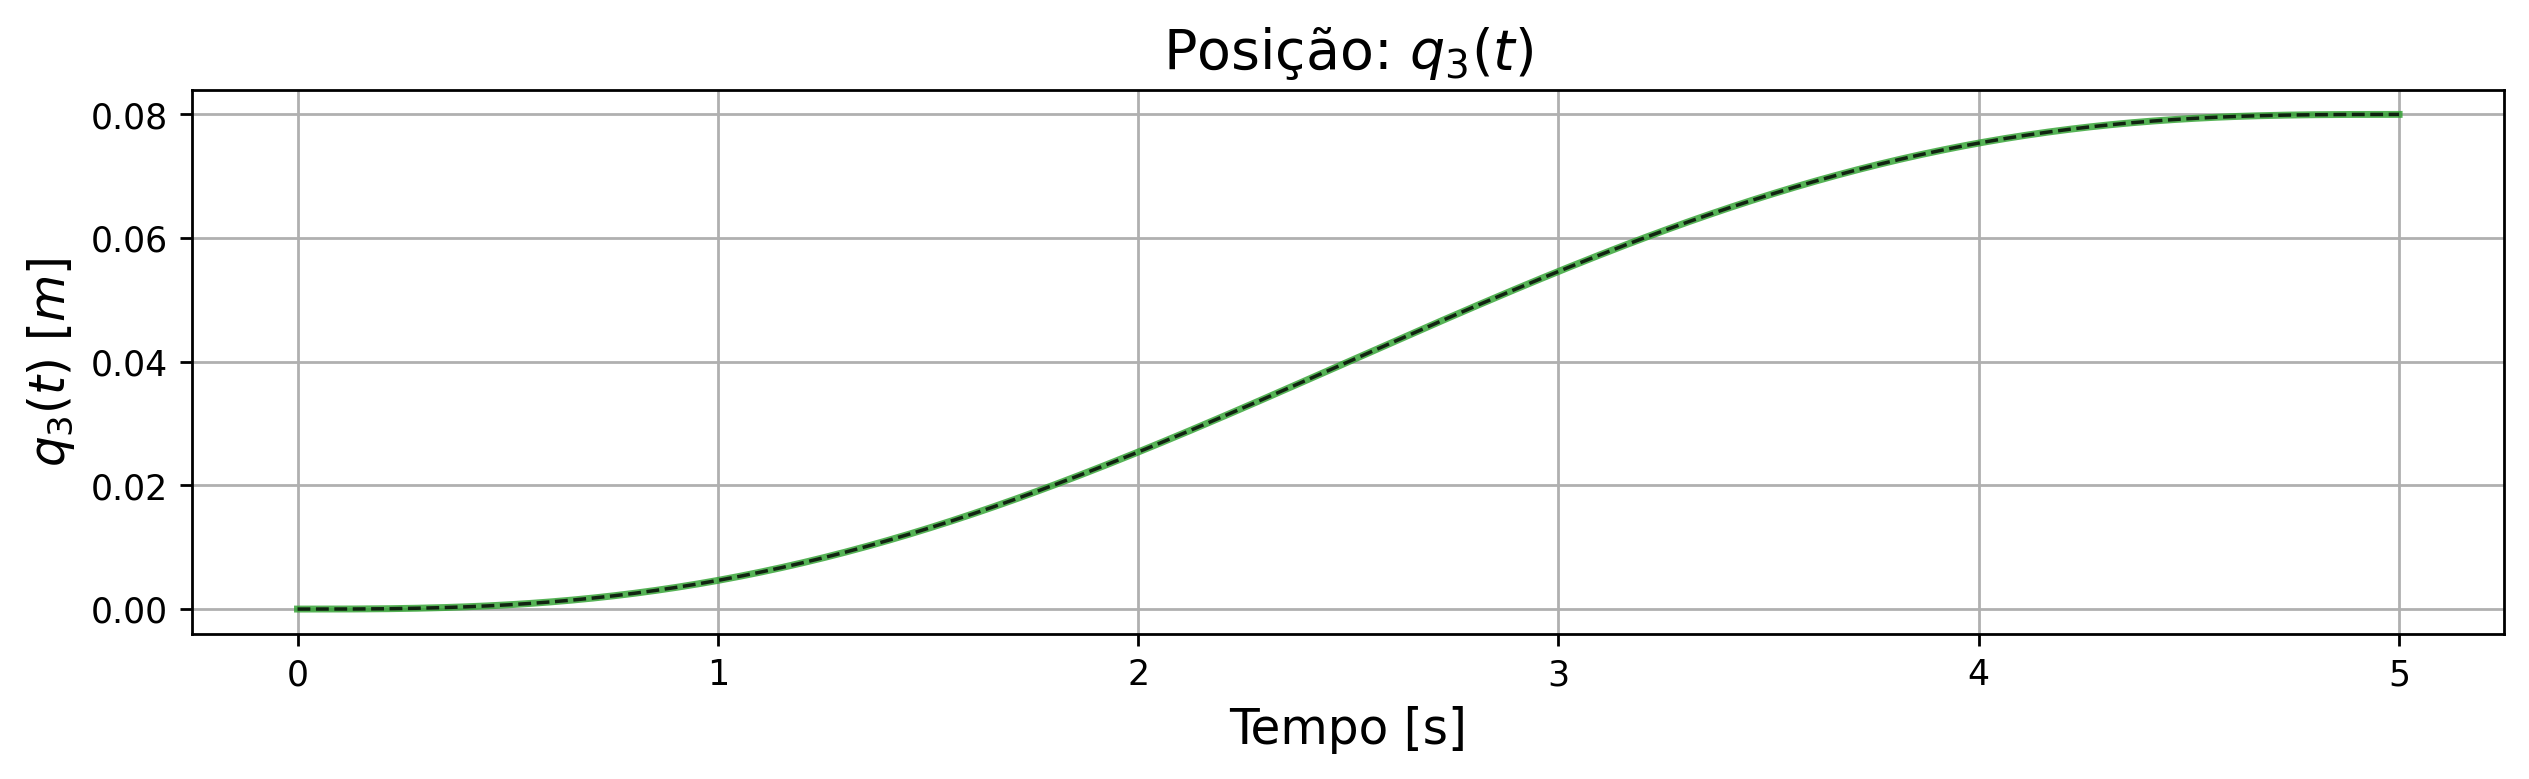

In [36]:
# Plot: Visualização individual
# plotar = 'dq'         # Pode ser 'q', 'dq', 'ddq', 'erro' ou 'tau'
i = 3                   # Junta a ser plotada (1, 2 ou 3)

i -= 1
fig, ax = plt.subplots(figsize=(10,3), layout='constrained', dpi=250)
ax.plot(tgrid, data[plotar].T[i], lw=2, alpha=.8, color=colors[i])
if plotar in ['q', 'dq', 'ddq']:
    ax.plot(tgrid, data_d[plotar].T[i], linestyle='--', color='k', lw=1, alpha=.8)
ax.set_title(f"{title[plotar][:title[plotar].find(':')]}: {lbl[plotar][i]}", fontsize=16)
ax.set_ylabel(f'{lbl[plotar][i]} {un[plotar][i]}', fontsize=14)
ax.set_xlabel('Tempo [s]', fontsize=14)
ax.grid()
